# Estimación del modelo estructural para la serie GNP que posee tendencia y ciclo

In [1]:
from pandas_datareader import DataReader
import numpy as np
import statsmodels.api as sm
import matplotlib.pylab as plt
import pandas as pd

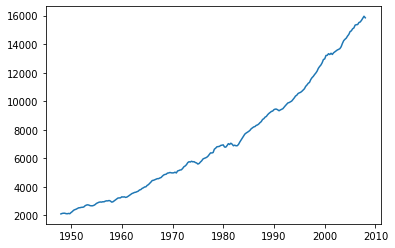

In [3]:
import warnings
warnings.filterwarnings('ignore') #Hide all warnings in ipython
start = '1948-01'
end = '2008-01'
us_gnp = DataReader('GNPC96', 'fred', start=start, end=end)
plt.plot(us_gnp)

Del gráfico se puede observar una evidente componente de tendencia creciente, en la medición del PIB trimestral de U.S.

Para analizar mejor esta serie de tiempo se aplica la transformación de logaritmo a los datos (sin realizar prubea Box-Cox)

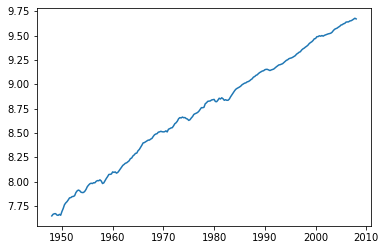

In [4]:
log_gnp = np.log(us_gnp)
dates = us_gnp.index._mpl_repr()
plt.plot(log_gnp)

## Especificación del modelo

Estamos en un **modelo estructural de espacio y estado** , el cual toma la forma general (sin incluir variables regresoras):
$y_t = \mu_t + \gamma_t + c_t + \varepsilon_t$ donde:

$y_t$ se refiere al vetor de observaciones en el tiempo $t$ 

$\mu_t$ se refiere a la componente de tendencia 

$\gamma_t$ se refiere a la componente estacional 

$c_t$ se refiere a la componente cíclica, y $\varepsilon_t$ es el ruido. 

Los detalles del modelo de estás componentes están dados abajo.

https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html#statsmodels.tsa.statespace.structural.UnobservedComponents

Para la componente de tendencia $\mu_t$, en clase (26/jun) se presentó el siguiente modelo:

$$\mu_{t+1} = \mu_t + \nu_t + \eta_{t+1} , \hspace{1cm} \eta_{t+1} \sim N(0, \sigma_{\eta}^2)$$

$$\nu_{t+1} = \nu_t + \zeta_{t+1} , \hspace{1cm} \zeta_{t+1} \sim N(0, \sigma_{\zeta}^2 )$$

En el modelo de espacio y estados se modela la tendencia, uno de los posibles modelos que puede ser usado es el **modelo de tendencia local lineal**, el cual se puede expresar como:

$$ y_t = \mu_t + \varepsilon_t, \hspace{1cm} \varepsilon \sim N(0, \sigma_{\varepsilon}^2)$$
$$ \mu_{t+1} = \mu_t + \nu_t + \xi_t, \hspace{1cm} \xi \sim N(0, \sigma_{\xi}^2) $$
$$ \nu_{t+1} = \nu_t + \zeta_t , \hspace{1cm} \zeta \sim N(0, \sigma_{\zeta}^2)  $$

In [5]:
unrestricted_model = {
    'level': 'local linear trend', 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True
}

output_mod = sm.tsa.UnobservedComponents(log_gnp, **unrestricted_model)
output_res = output_mod.fit(method='powell', disp=False)
print(output_res.summary())

                            Unobserved Components Results                            
Dep. Variable:                        GNPC96   No. Observations:                  241
Model:                    local linear trend   Log Likelihood                 769.632
                   + damped stochastic cycle   AIC                          -1527.264
Date:                       Wed, 26 Jun 2019   BIC                          -1506.455
Time:                               19:17:27   HQIC                         -1518.877
Sample:                           01-01-1948                                         
                                - 01-01-2008                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular   1.09e-06   7.29e-06      0.150      0

Los supuestos del modelo de espacio y estados lineal general se pueden probar igual que en el caso de los modelos de tendencia local, es decir se comprueban sobre los residuales $e_t$. En los test que se tienen que llevar a cabo para validar el modelo, nos podemos "suavizar" con el resultado del test de *Ljung-Box* para la **autocorrelación**, dado que (las $y_t$'s???) van a estar correlacionadas

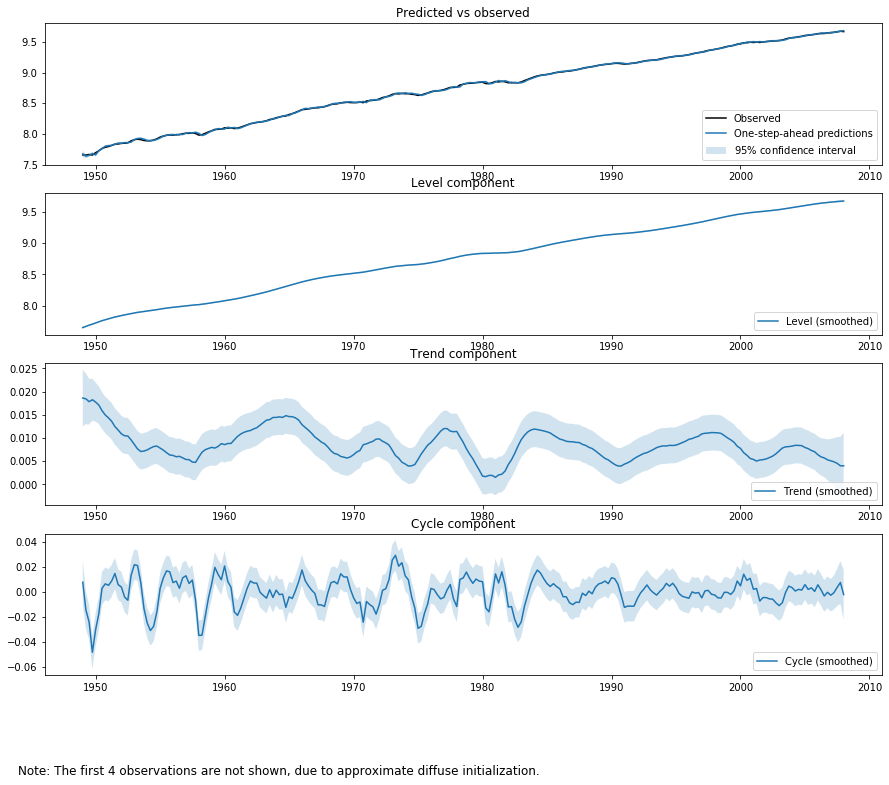

In [15]:
fig = output_res.plot_components(legend_loc='lower right', figsize=(15, 12));

## Pronóstico

In [20]:
output_res.forecast(12) #pronóstico 12 pasos (trimestres) adelante
log_gnp_forecast=output_res.get_prediction(start='2008-04-01', end='2009-01-01') #predicción de los siguientes cuatro trimestres

In [16]:
forecast = log_gnp_forecast.predicted_mean
print(forecast)
ci = log_gnp_forecast.conf_int(alpha=0.5)
print(ci)

2008-04-01    9.673601
2008-07-01    9.677221
2008-10-01    9.681674
2009-01-01    9.686674
Freq: QS-OCT, dtype: float64
            lower GNPC96  upper GNPC96
2008-04-01      9.667343      9.679859
2008-07-01      9.666744      9.687699
2008-10-01      9.667205      9.696144
2009-01-01      9.668506      9.704842


In [21]:
arraypronosticosSTIC={'pronostico':forecast.values,'li':ci['lower GNPC96'].values,'ls':ci['upper GNPC96'].values}
indice=pd.date_range(start='2008-04-01',end='2009-01-01',freq='QS')
pronosticosSTIC=pd.DataFrame(data=arraypronosticosSTIC,index=indice)
print(pronosticosSTIC)

            pronostico        li        ls
2008-04-01    9.673601  9.667343  9.679859
2008-07-01    9.677221  9.666744  9.687699
2008-10-01    9.681674  9.667205  9.696144
2009-01-01    9.686674  9.668506  9.704842


In [11]:
#####Función inversa Box-Cox######
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [27]:
####Se devuelve  a la escala original
for column in ['pronostico', 'li', 'ls']:
    pronosticosSTIC[column] = inverse_boxcox(pronosticosSTIC[column],0)

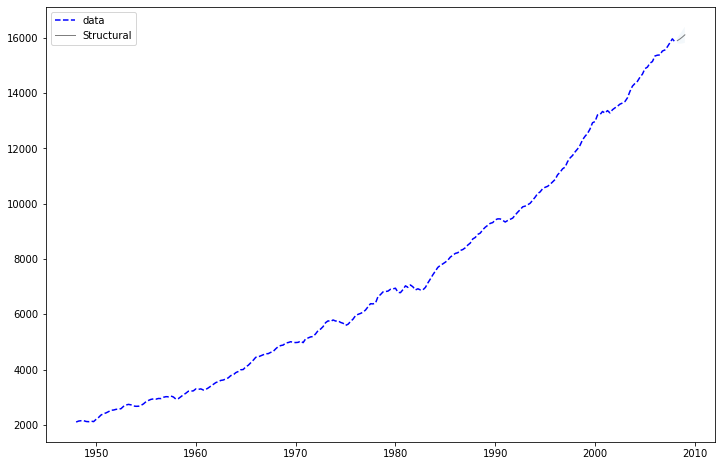

In [13]:
#######Gráfica de los pronósticos#####
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)
#Actual data: los valores de la serie gnp original en línea punteada azul
ax.plot(us_gnp.astype('float64'), '--', color="blue", label='data')
# Means: los promedios de las predicciones (con get_prediction) de los siguientes trimestres
ax.plot(pronosticosSTIC['pronostico'], lw=1, color="black", alpha=0.5, label='Structural')
# Las bandas de pronóstico, construidas con las columnas dos (.iloc[:,1]) y tres (.iloc[:,2]) de pronosticosSTIC
ax.fill_between(pronosticosSTIC['pronostico'].index, pronosticosSTIC.iloc[:, 1], pronosticosSTIC.iloc[:, 2], alpha=0.05)
# El recuadro en la izquierda superior
ax.legend(loc='upper left')
plt.draw()

In [14]:
from sklearn.metrics import mean_squared_error # tuve que instalarlo con: > pip install sklearn (cuidado puede fallar el ambiente 'lala')
X = log_gnp.values
size = int(len(X) * 0.8) # toma el entero del producto de la longitud del vector X y 0.8
train, test = X[0:size], X[size:len(X)] #define dos vectores train(muestra de entrenamiento) y test(muestra de prueba)
history = [x for x in train] # inicializa el vector history
predicciones = list() #lista o vector nulo donde se guardará los valores de las predicciones un paso adelante
for t in range(len(test)): 
    # t va a recorrer desde cero hasta la longitud del vector test
	output_mod = sm.tsa.UnobservedComponents(history, **unrestricted_model)
    # define el modelo de espacio y estados para el vector history
	modelo_fit = output_mod.fit(method='powell', disp=False) # ajusta el modelo
	output = modelo_fit.forecast()  ####Especificar los pasos adelante
	yhat = output[0] # define yhat como el primer valor del pronóstico un paso adelante
	predicciones.append(np.exp(yhat)) #agrega al final del vector predicciones, la predicción un paso adelante del vector history
	obs = test[t] #asigna a obs la t-ésima componente del vector test, que va cambiando en cada iteración
	history.append(obs) #agrega al final del vector history el valor de obs, que es la t-ésima componente del vector test
	print('Predicción=%f, Esperado=%f' % (np.exp(yhat), np.exp(obs)))
error = mean_squared_error(np.exp(test), predicciones)
print('ECM: %.3f' % error)

Predicción=10872.096413, Esperado=10872.421000
Predicción=10966.732047, Esperado=11041.392000
Predicción=11165.399923, Esperado=11135.535000
Predicción=11237.691864, Esperado=11258.169000
Predicción=11364.602578, Esperado=11319.212000
Predicción=11403.487519, Esperado=11516.945000
Predicción=11641.129942, Esperado=11650.143000
Predicción=11767.356918, Esperado=11740.681000
Predicción=11842.693386, Esperado=11869.712000
Predicción=11979.972997, Esperado=11975.231000
Predicción=12094.306351, Esperado=12107.382000
Predicción=12226.947611, Esperado=12306.035000
Predicción=12457.520911, Esperado=12434.656000
Predicción=12573.712458, Esperado=12536.319000
Predicción=12660.147893, Esperado=12695.786000
Predicción=12834.713071, Esperado=12923.768000
Predicción=13089.060759, Esperado=12965.481000
Predicción=13087.320819, Esperado=13205.975000
Predicción=13375.205100, Esperado=13217.516000
Predicción=13330.354177, Esperado=13330.887000
Predicción=13456.140729, Esperado=13274.505000
Predicción=13